In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

from scipy import stats

from sklearn import metrics
import sklearn as sk
from sklearn.feature_selection import RFECV
from sklearn.base import clone 
import statistics

from sklearn.model_selection import train_test_split


## Preprocess HDB Dataset

In [ ]:
df = pd.read_csv("HDB Final.csv")
town_sentiment = pd.read_csv("townsentiments3.csv")
school_rank = pd.read_csv("PriSchoolRank.csv")

In [ ]:
df = df.merge(school_rank, on='Nearest Primary School', how='left')

In [ ]:
town_sentiment = town_sentiment.groupby(["Town"]).mean().reset_index()

In [ ]:
town_sentiment["Town"] = town_sentiment["Town"].str.upper()

In [ ]:
town_sentiment["Town"] = town_sentiment["Town"].str.replace("CENTRAL" ,"CENTRAL AREA")
df = df.merge(town_sentiment, left_on='town', right_on="Town", how='left')
df["town"] = df["Vader_score"]

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 0.1,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,...,Dist from Shopping Mall,Nearest Shopping Mall,Dist from Nearest Supermarket,Nearest Supermarket,Rank,Town,Textblob_score,Vader_score,flair_sentiment,bert_sentiment
0,0,0,1,0.145237,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,...,1.023055,AMK Hub,0.385974,G8 MART PTE. LTD.,165,ANG MO KIO,0.078652,0.145237,-0.410571,-0.65443
1,1,1,1,0.145237,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,...,0.870217,Broadway Plaza,0.395388,COLD STORAGE SINGAPORE (1983) PTE LTD,151,ANG MO KIO,0.078652,0.145237,-0.410571,-0.65443
2,2,2,1,0.145237,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,...,1.535061,Broadway Plaza,0.884793,COLD STORAGE SINGAPORE (1983) PTE LTD,152,ANG MO KIO,0.078652,0.145237,-0.410571,-0.65443
3,3,3,1,0.145237,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,...,0.923157,myVillage At Serangoon Garden,0.468595,G8 MART PTE. LTD.,79,ANG MO KIO,0.078652,0.145237,-0.410571,-0.65443
4,4,4,1,0.145237,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,...,1.567164,Broadway Plaza,0.929657,COLD STORAGE SINGAPORE (1983) PTE LTD,152,ANG MO KIO,0.078652,0.145237,-0.410571,-0.65443


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134516 entries, 0 to 134515
Data columns (total 42 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         134516 non-null  int64  
 1   Unnamed: 0.1                       134516 non-null  int64  
 2   month                              134516 non-null  int64  
 3   town                               134516 non-null  float64
 4   flat_type                          134516 non-null  object 
 5   block                              134516 non-null  object 
 6   street_name                        134516 non-null  object 
 7   storey_range                       134516 non-null  object 
 8   floor_area_sqm                     134516 non-null  float64
 9   flat_model                         134516 non-null  object 
 10  lease_commence_date                134516 non-null  int64  
 11  remaining_lease                    1345

In [ ]:
#Processing remaning lease years

df['remaining_lease_years'] = df['remaining_lease'].str.split(' ').str[0]
df['remaining_lease_years'] = pd.to_numeric(df['remaining_lease_years'])

In [ ]:
#Process storey range to low med and high
def get_median(x):
    split_list = x.split(' TO ')
    float_list = [float(i) for i in split_list]
    median = statistics.median(float_list)
    return median
df['storey_range'] = df['storey_range'].apply(lambda x: get_median(x))

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 0.1,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,...,Nearest Shopping Mall,Dist from Nearest Supermarket,Nearest Supermarket,Rank,Town,Textblob_score,Vader_score,flair_sentiment,bert_sentiment,remaining_lease_years
0,0,0,1,0.145237,2 ROOM,406,ANG MO KIO AVE 10,11.0,44.0,Improved,...,AMK Hub,0.385974,G8 MART PTE. LTD.,165,ANG MO KIO,0.078652,0.145237,-0.410571,-0.65443,61
1,1,1,1,0.145237,3 ROOM,108,ANG MO KIO AVE 4,2.0,67.0,New Generation,...,Broadway Plaza,0.395388,COLD STORAGE SINGAPORE (1983) PTE LTD,151,ANG MO KIO,0.078652,0.145237,-0.410571,-0.65443,60
2,2,2,1,0.145237,3 ROOM,602,ANG MO KIO AVE 5,2.0,67.0,New Generation,...,Broadway Plaza,0.884793,COLD STORAGE SINGAPORE (1983) PTE LTD,152,ANG MO KIO,0.078652,0.145237,-0.410571,-0.65443,62
3,3,3,1,0.145237,3 ROOM,465,ANG MO KIO AVE 10,5.0,68.0,New Generation,...,myVillage At Serangoon Garden,0.468595,G8 MART PTE. LTD.,79,ANG MO KIO,0.078652,0.145237,-0.410571,-0.65443,62
4,4,4,1,0.145237,3 ROOM,601,ANG MO KIO AVE 5,2.0,67.0,New Generation,...,Broadway Plaza,0.929657,COLD STORAGE SINGAPORE (1983) PTE LTD,152,ANG MO KIO,0.078652,0.145237,-0.410571,-0.65443,62


In [ ]:
df = pd.get_dummies(df, columns = ['flat_type'])

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 0.1,month,town,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,flair_sentiment,bert_sentiment,remaining_lease_years,flat_type_1 ROOM,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION
0,0,0,1,0.145237,406,ANG MO KIO AVE 10,11.0,44.0,Improved,1979,...,-0.410571,-0.65443,61,0,1,0,0,0,0,0
1,1,1,1,0.145237,108,ANG MO KIO AVE 4,2.0,67.0,New Generation,1978,...,-0.410571,-0.65443,60,0,0,1,0,0,0,0
2,2,2,1,0.145237,602,ANG MO KIO AVE 5,2.0,67.0,New Generation,1980,...,-0.410571,-0.65443,62,0,0,1,0,0,0,0
3,3,3,1,0.145237,465,ANG MO KIO AVE 10,5.0,68.0,New Generation,1980,...,-0.410571,-0.65443,62,0,0,1,0,0,0,0
4,4,4,1,0.145237,601,ANG MO KIO AVE 5,2.0,67.0,New Generation,1980,...,-0.410571,-0.65443,62,0,0,1,0,0,0,0


In [ ]:
#Drop columns that are not features or can be captured by other columns

df["school_rank"] = df["Rank"]
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'lease_commence_date', 'lat', 'lng', "remaining_lease", "block", 
                      "street_name", "Nearest Expressway", "Nearest Hawker Centre", "Nearest Public Hospital", "Nearest MRT"
                      , "Nearest Park", "Nearest Polyclinic", "Nearest Primary School", "Nearest Shopping Mall", "Nearest Supermarket", 
                     "Address", "Rank", 'flat_model', "Textblob_score", "Vader_score", "flair_sentiment", "bert_sentiment", "Town"])

<AxesSubplot:>

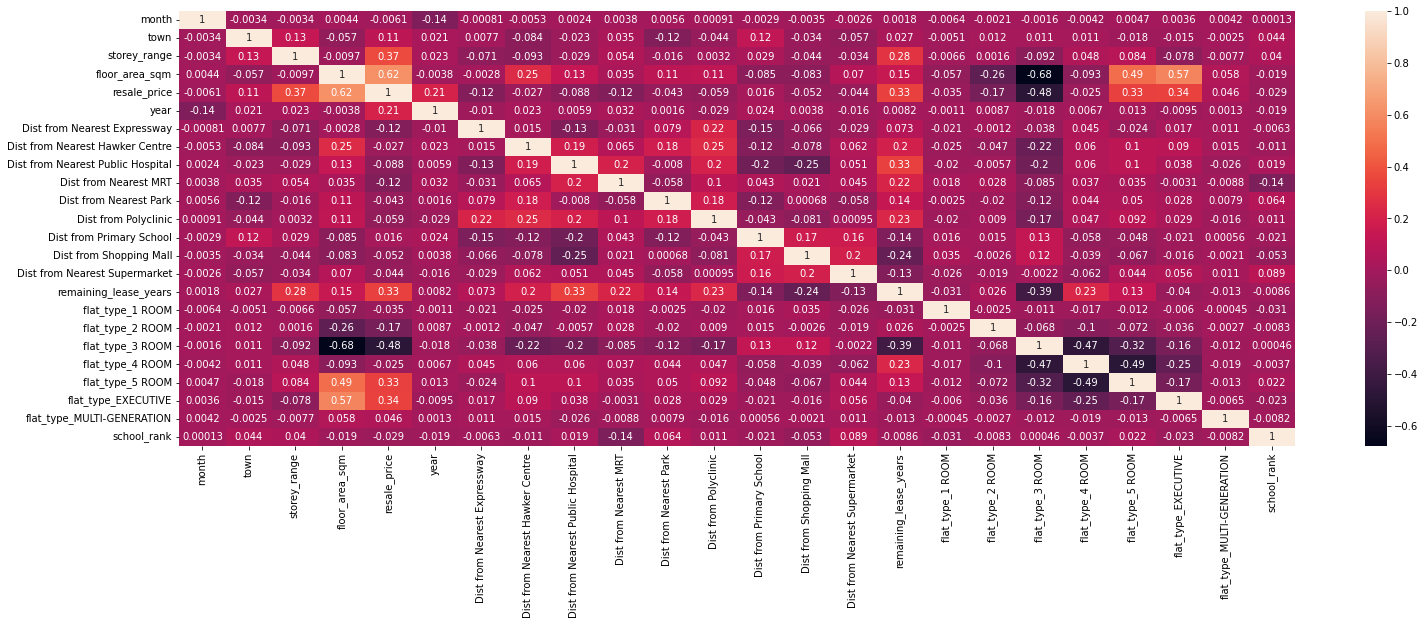

In [ ]:
plt.figure(figsize=(25,8))
sns.heatmap(df.corr(), annot=True)

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df['date'] 

0        2017-01-01
1        2017-01-01
2        2017-01-01
3        2017-01-01
4        2017-01-01
            ...    
134511   2022-08-01
134512   2022-08-01
134513   2022-08-01
134514   2022-08-01
134515   2022-08-01
Name: date, Length: 134516, dtype: datetime64[ns]

In [ ]:
hdb_before_covid = df[df["date"] <= '2020-03-01']
hdb_after_covid = df[df["date"] >= '2020-04-01']

In [ ]:
hdb_before_covid = hdb_before_covid.drop(columns=['date'])
hdb_after_covid = hdb_after_covid.drop(columns=['date'])

In [ ]:
hdb_before_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69765 entries, 0 to 69764
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   month                              69765 non-null  int64  
 1   town                               69765 non-null  float64
 2   storey_range                       69765 non-null  float64
 3   floor_area_sqm                     69765 non-null  float64
 4   resale_price                       69765 non-null  float64
 5   year                               69765 non-null  int64  
 6   Dist from Nearest Expressway       69765 non-null  float64
 7   Dist from Nearest Hawker Centre    69765 non-null  float64
 8   Dist from Nearest Public Hospital  69765 non-null  float64
 9   Dist from Nearest MRT              69765 non-null  float64
 10  Dist from Nearest Park             69765 non-null  float64
 11  Dist from Polyclinic               69765 non-null  flo

In [ ]:
hdb_after_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64751 entries, 69765 to 134515
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   month                              64751 non-null  int64  
 1   town                               64751 non-null  float64
 2   storey_range                       64751 non-null  float64
 3   floor_area_sqm                     64751 non-null  float64
 4   resale_price                       64751 non-null  float64
 5   year                               64751 non-null  int64  
 6   Dist from Nearest Expressway       64751 non-null  float64
 7   Dist from Nearest Hawker Centre    64751 non-null  float64
 8   Dist from Nearest Public Hospital  64751 non-null  float64
 9   Dist from Nearest MRT              64751 non-null  float64
 10  Dist from Nearest Park             64751 non-null  float64
 11  Dist from Polyclinic               64751 non-null

<AxesSubplot:>

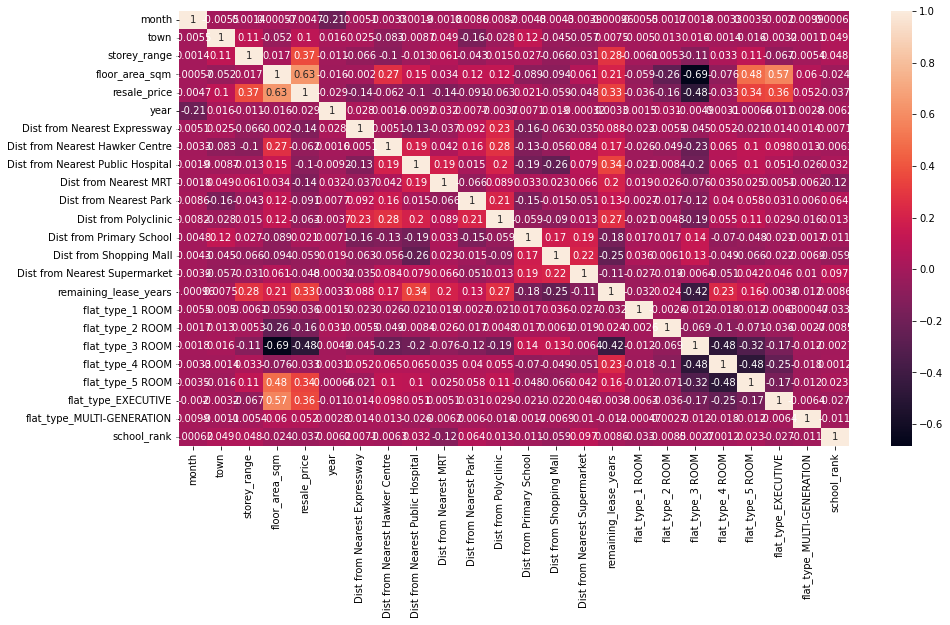

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(hdb_before_covid.corr(), annot=True)

<AxesSubplot:>

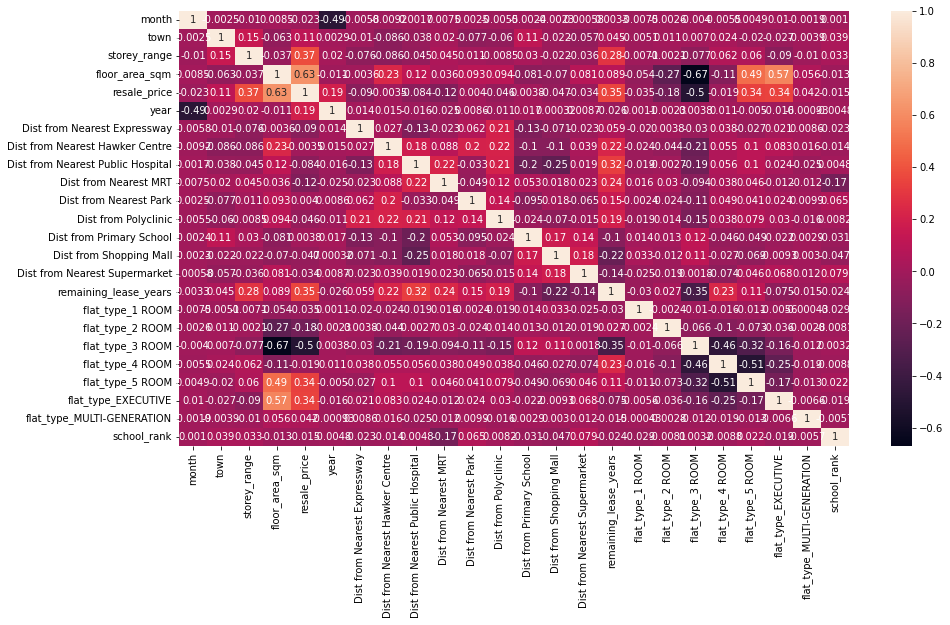

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(hdb_after_covid.corr(), annot=True)

## Remove Outlier

C:\Users\yuhao\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='resale_price', ylabel='Density'>

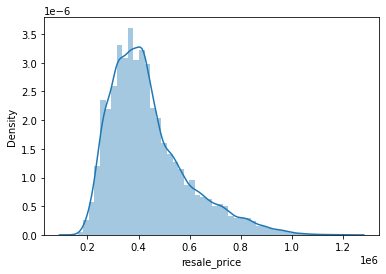

In [ ]:
sns.distplot(hdb_before_covid['resale_price'])

C:\Users\yuhao\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='resale_price', ylabel='Density'>

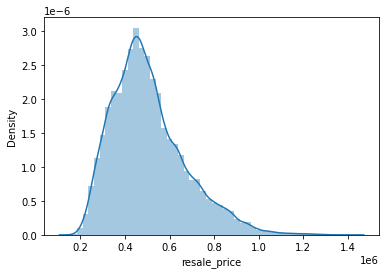

In [ ]:
sns.distplot(hdb_after_covid['resale_price'])

C:\Users\yuhao\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='resale_price'>

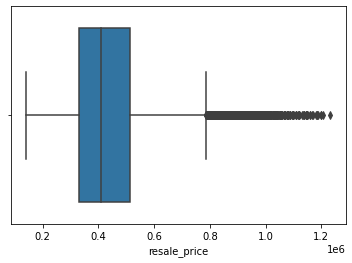

In [ ]:
sns.boxplot(hdb_before_covid['resale_price'])

<AxesSubplot:ylabel='resale_price'>

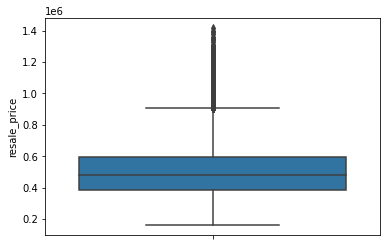

In [ ]:
sns.boxplot(y= hdb_after_covid['resale_price'])

In [ ]:
hdb_before_covid.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
month,0.029850,-1.201466
town,0.683465,0.539212
storey_range,1.551718,4.364973
floor_area_sqm,0.249790,-0.165235
resale_price,1.136192,1.283894
year,0.190587,-1.027372
Dist from Nearest Expressway,1.490214,1.886769
Dist from Nearest Hawker Centre,1.391180,2.053718
Dist from Nearest Public Hospital,0.083291,-1.294120
Dist from Nearest MRT,1.171096,1.590999


In [ ]:
hdb_after_covid.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
month,-0.089407,-1.006052
town,0.668352,0.409573
storey_range,1.660393,4.616427
floor_area_sqm,0.272851,-0.019131
resale_price,0.906575,1.003296
year,-0.000394,-1.184414
Dist from Nearest Expressway,1.611579,2.629888
Dist from Nearest Hawker Centre,1.387503,2.073649
Dist from Nearest Public Hospital,0.063357,-1.329787
Dist from Nearest MRT,0.979983,0.816698


In [ ]:
outliers_col = ['resale_price', 'Dist from Nearest Expressway', 'Dist from Nearest Hawker Centre', 'Dist from Nearest Public Hospital',
                'Dist from Nearest MRT', 'Dist from Nearest Park', 'Dist from Polyclinic','Dist from Primary School'
               , 'Dist from Shopping Mall', 'Dist from Nearest Supermarket', 'floor_area_sqm', 'remaining_lease_years']
for col in outliers_col:
    hdb_before_covid = hdb_before_covid[(np.abs(stats.zscore(hdb_before_covid[col])) < 3)]
hdb_before_covid.describe()

,month,town,storey_range,floor_area_sqm,resale_price,year,Dist from Nearest Expressway,Dist from Nearest Hawker Centre,Dist from Nearest Public Hospital,Dist from Nearest MRT,...,Dist from Nearest Supermarket,remaining_lease_years,flat_type_1 ROOM,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,school_rank
count,61039.000000,61039.000000,61039.000000,61039.000000,61039.000000,61039.000000,61039.000000,61039.000000,61039.000000,61039.000000,...,61039.000000,61039.000000,61039.000000,61039.000000,61039.000000,61039.000000,61039.000000,61039.00000,61039.000000,61039.000000
mean,6.395681,0.139132,8.400564,97.058913,437383.685153,2018.178165,1.116215,0.704857,4.007743,0.748665,...,0.287020,73.655958,0.000524,0.013565,0.252199,0.415407,0.241927,0.07605,0.000328,93.891070
std,3.391012,0.072647,5.397988,23.924828,144614.686694,0.946464,0.881876,0.472872,2.317305,0.414145,...,0.143210,12.585689,0.022891,0.115678,0.434279,0.492796,0.428254,0.26508,0.018099,52.238818
min,1.000000,0.002437,2.000000,31.000000,140000.000000,2017.000000,0.008429,0.000000,0.113112,0.031202,...,0.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
25%,3.000000,0.069594,5.000000,76.000000,330000.000000,2017.000000,0.467476,0.336649,1.832646,0.444406,...,0.179538,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,49.000000
50%,6.000000,0.143241,8.000000,95.000000,410000.000000,2018.000000,0.888025,0.604062,3.948951,0.660983,...,0.271906,73.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,93.000000
75%,9.000000,0.172171,11.000000,112.000000,515000.000000,2019.000000,1.465464,0.961120,5.907285,0.966931,...,0.378607,83.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,139.000000
max,12.000000,0.352224,41.000000,170.000000,899000.000000,2020.000000,4.099662,2.345469,8.390357,2.105787,...,0.783282,96.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,186.000000


In [ ]:
outliers_col = ['resale_price', 'Dist from Nearest Expressway', 'Dist from Nearest Hawker Centre', 'Dist from Nearest Public Hospital',
                'Dist from Nearest MRT', 'Dist from Nearest Park', 'Dist from Polyclinic','Dist from Primary School'
               , 'Dist from Shopping Mall', 'Dist from Nearest Supermarket', 'floor_area_sqm', 'remaining_lease_years']
for col in outliers_col:
    hdb_after_covid = hdb_after_covid[(np.abs(stats.zscore(hdb_after_covid[col])) < 3)]
hdb_after_covid.describe()

,month,town,storey_range,floor_area_sqm,resale_price,year,Dist from Nearest Expressway,Dist from Nearest Hawker Centre,Dist from Nearest Public Hospital,Dist from Nearest MRT,...,Dist from Nearest Supermarket,remaining_lease_years,flat_type_1 ROOM,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,school_rank
count,56640.000000,56640.000000,56640.000000,56640.000000,5.664000e+04,56640.000000,56640.000000,56640.000000,56640.000000,56640.000000,...,56640.000000,56640.000000,56640.000000,56640.000000,56640.000000,56640.000000,56640.000000,56640.000000,56640.000000,56640.000000
mean,6.647175,0.142275,8.802966,97.191871,5.057519e+05,2020.997334,1.041455,0.717813,4.118333,0.783324,...,0.283486,74.214001,0.000424,0.014107,0.234622,0.421416,0.255879,0.073076,0.000477,92.331197
std,3.267499,0.075390,5.973489,23.609596,1.601061e+05,0.740633,0.786029,0.471352,2.361420,0.432849,...,0.143198,14.642075,0.020580,0.117932,0.423766,0.493790,0.436358,0.260263,0.021828,51.788145
min,1.000000,0.002437,2.000000,31.000000,1.600000e+05,2020.000000,0.008429,0.000000,0.113112,0.031202,...,0.000000,43.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4.000000,0.069594,5.000000,82.000000,3.888880e+05,2020.000000,0.448250,0.354747,1.888476,0.462485,...,0.173457,62.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000
50%,7.000000,0.143241,8.000000,93.000000,4.800000e+05,2021.000000,0.877345,0.623154,4.106446,0.691165,...,0.268835,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.000000
75%,9.000000,0.175077,11.000000,113.000000,6.000000e+05,2022.000000,1.366239,0.982988,6.396826,1.030601,...,0.376890,91.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,134.000000
max,12.000000,0.352224,47.000000,169.000000,1.000888e+06,2022.000000,3.892466,2.387042,8.390357,2.128582,...,0.766712,97.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,186.000000


## Train Test Split

In [ ]:
hdb_before_covid_x = hdb_before_covid.drop(columns=['resale_price'])
hdb_before_covid_y = np.log(hdb_before_covid["resale_price"])

In [ ]:
X_train_before, X_test_before, y_train_before, y_test_before = train_test_split(hdb_before_covid_x, hdb_before_covid_y, test_size=0.3, random_state=123)

X_test_before, X_val_before, y_test_before, y_val_before = train_test_split(X_test_before, y_test_before, test_size=0.5, random_state=123)

In [ ]:
print("Train length:", len(X_train_before), "Test length:", len(X_test_before), "Val length:", len(X_val_before))

Train length: 42727 Test length: 9156 Val length: 9156


In [ ]:
hdb_after_covid_x = hdb_after_covid.drop(columns=['resale_price'])
hdb_after_covid_y = np.log(hdb_after_covid["resale_price"])

In [ ]:
X_train_after, X_test_after, y_train_after, y_test_after = train_test_split(hdb_after_covid_x, hdb_after_covid_y, test_size=0.3, random_state=123)

X_test_after, X_val_after, y_test_after, y_val_after = train_test_split(X_test_after, y_test_after, test_size=0.5, random_state=123)

In [ ]:
print("Train length:", len(X_train_after), "Test length:", len(X_test_after), "Val length:", len(X_val_after))

Train length: 39648 Test length: 8496 Val length: 8496


## Scaling/Normalization

In [ ]:
cols_to_scale = X_train_before.columns

scaler_before = MinMaxScaler()
X_train_before[cols_to_scale] = scaler_before.fit_transform(X_train_before[cols_to_scale])
X_train_before

,month,town,storey_range,floor_area_sqm,year,Dist from Nearest Expressway,Dist from Nearest Hawker Centre,Dist from Nearest Public Hospital,Dist from Nearest MRT,Dist from Nearest Park,...,Dist from Nearest Supermarket,remaining_lease_years,flat_type_1 ROOM,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,school_rank
52884,0.545455,0.763649,0.000000,0.446043,0.666667,0.088663,0.452549,0.778514,0.522321,0.174601,...,0.187347,0.921569,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.718919
43298,0.000000,0.191993,0.076923,0.690647,0.666667,0.118425,0.780881,0.212540,0.161323,0.481781,...,0.346685,0.549020,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.767568
31327,0.545455,0.284087,0.000000,0.697842,0.333333,0.095985,0.780777,0.668842,0.544066,0.297086,...,0.240608,0.627451,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.167568
39892,0.909091,1.000000,0.153846,0.244604,0.333333,0.471030,0.103754,0.244994,0.088349,0.114018,...,0.163389,0.176471,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.951351
39459,0.909091,0.273442,0.000000,0.841727,0.333333,0.556636,0.274514,0.814423,0.389269,0.282938,...,0.447233,0.411765,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.254054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62073,0.909091,0.000000,0.384615,0.633094,0.666667,0.176825,0.449984,0.443017,0.389626,0.104054,...,0.206513,0.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.221622
20136,1.000000,0.493556,0.230769,0.302158,0.000000,0.475957,0.524908,0.529752,0.166027,0.278057,...,0.466231,0.274510,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.356757
31831,0.545455,0.510829,0.230769,0.395683,0.333333,0.982073,0.326040,0.460576,0.227950,0.703696,...,0.127596,0.705882,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.216216
17841,0.909091,0.284087,0.076923,0.568345,0.000000,0.308018,0.419037,0.561130,0.351936,0.392854,...,0.536637,0.862745,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.167568


In [ ]:
cols_to_scale = X_train_after.columns
X_train_after = X_train_after

scaler_after = MinMaxScaler()
X_train_after[cols_to_scale] = scaler_after.fit_transform(X_train_after[cols_to_scale])
X_train_after

,month,town,storey_range,floor_area_sqm,year,Dist from Nearest Expressway,Dist from Nearest Hawker Centre,Dist from Nearest Public Hospital,Dist from Nearest MRT,Dist from Nearest Park,...,Dist from Nearest Supermarket,remaining_lease_years,flat_type_1 ROOM,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,school_rank
101787,0.545455,0.763649,0.466667,0.434783,0.5,0.275540,0.353059,0.641064,0.503434,0.360197,...,0.249250,0.685185,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.854054
119339,0.090909,0.348701,0.466667,0.268116,1.0,0.046181,0.159606,0.135704,0.293711,0.787186,...,0.437401,0.944444,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.794595
111185,0.818182,0.191993,0.200000,0.384058,0.5,0.204267,0.548036,0.230977,0.285032,0.294557,...,0.421379,0.370370,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.081081
129355,0.454545,0.191993,0.000000,0.239130,1.0,0.446543,0.316266,0.238922,0.598532,0.713521,...,0.317041,0.370370,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.048649
108109,0.727273,0.174598,0.266667,0.579710,0.5,0.017535,0.318515,0.856106,0.751332,0.338422,...,0.532001,0.703704,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.286486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131823,0.545455,0.000000,0.133333,0.528986,1.0,0.040773,0.229359,0.147358,0.420027,0.453594,...,0.367323,0.407407,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.059459
89993,0.000000,0.402543,0.200000,0.442029,0.5,0.862921,0.126883,0.053089,0.418801,0.142391,...,0.463069,0.888889,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.443243
101671,0.545455,0.342326,0.000000,0.333333,0.5,0.080075,0.089219,0.053551,0.215567,0.049051,...,0.257471,0.129630,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.697297
87711,0.000000,0.407461,0.066667,0.268116,0.5,0.060069,0.077074,0.455709,0.191995,0.172880,...,0.142007,0.296296,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.891892


## Feature Selection (Before Covid)

In [ ]:
#RF = RandomForestRegressor(n_estimators=50, random_state=0)
#rfecv = RFECV(estimator=RF, min_features_to_select=2, cv=5)

#selector = rfecv.fit(hdb_before_covid_x, hdb_before_covid['resale_price'])
#to_discard = [hdb_before_covid_x.columns[i] for i in range(len(hdb_before_covid_x.columns)) if not selector.support_[i]]
#print("Features to discard: {}".format(to_discard))

In [ ]:
X_train_before.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42727 entries, 52884 to 60235
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   month                              42727 non-null  float64
 1   town                               42727 non-null  float64
 2   storey_range                       42727 non-null  float64
 3   floor_area_sqm                     42727 non-null  float64
 4   year                               42727 non-null  float64
 5   Dist from Nearest Expressway       42727 non-null  float64
 6   Dist from Nearest Hawker Centre    42727 non-null  float64
 7   Dist from Nearest Public Hospital  42727 non-null  float64
 8   Dist from Nearest MRT              42727 non-null  float64
 9   Dist from Nearest Park             42727 non-null  float64
 10  Dist from Polyclinic               42727 non-null  float64
 11  Dist from Primary School           42727 non-null 

In [ ]:
#Backward elimination 
import statsmodels.api as sm

cols = list(X_train_before.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X = X_train_before[cols]
    X = sm.add_constant(X)
    model = sm.OLS(y_train_before,X).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print('selected features:',selected_features_BE)
print('total number of selected features:',len(selected_features_BE))

selected features: ['month', 'town', 'storey_range', 'floor_area_sqm', 'year', 'Dist from Nearest Expressway', 'Dist from Nearest Hawker Centre', 'Dist from Nearest Public Hospital', 'Dist from Nearest MRT', 'Dist from Nearest Park', 'Dist from Polyclinic', 'Dist from Primary School', 'Dist from Shopping Mall', 'Dist from Nearest Supermarket', 'remaining_lease_years', 'flat_type_1 ROOM', 'flat_type_2 ROOM', 'flat_type_3 ROOM', 'flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_EXECUTIVE', 'flat_type_MULTI-GENERATION', 'school_rank']
total number of selected features: 23


In [ ]:
reg = LassoCV()
reg.fit(X_train_before, y_train_before)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train_before,y_train_before))
coef = pd.Series(reg.coef_, index = X_train_before.columns)
pd_coef = pd.DataFrame({'feature':coef.index, 'coeff':coef.values})

Best alpha using built-in LassoCV: 0.000081
Best score using built-in LassoCV: 0.771154


In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 21 variables and eliminated the other 2 variables


Text(0.5, 1.0, 'Feature importance using Lasso')

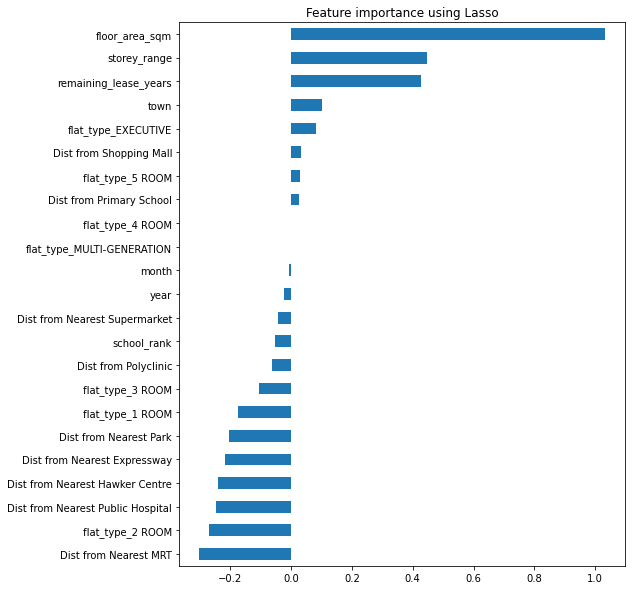

In [ ]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso")

In [ ]:
em_cols = pd_coef.loc[pd_coef['coeff'] != 0, 'feature']
X_train_before = X_train_before[em_cols].copy()

X_train_before.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42727 entries, 52884 to 60235
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   month                              42727 non-null  float64
 1   town                               42727 non-null  float64
 2   storey_range                       42727 non-null  float64
 3   floor_area_sqm                     42727 non-null  float64
 4   year                               42727 non-null  float64
 5   Dist from Nearest Expressway       42727 non-null  float64
 6   Dist from Nearest Hawker Centre    42727 non-null  float64
 7   Dist from Nearest Public Hospital  42727 non-null  float64
 8   Dist from Nearest MRT              42727 non-null  float64
 9   Dist from Nearest Park             42727 non-null  float64
 10  Dist from Polyclinic               42727 non-null  float64
 11  Dist from Primary School           42727 non-null 

## Feature Selection (After Covid)

In [ ]:
X_train_after.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39648 entries, 101787 to 129978
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   month                              39648 non-null  float64
 1   town                               39648 non-null  float64
 2   storey_range                       39648 non-null  float64
 3   floor_area_sqm                     39648 non-null  float64
 4   year                               39648 non-null  float64
 5   Dist from Nearest Expressway       39648 non-null  float64
 6   Dist from Nearest Hawker Centre    39648 non-null  float64
 7   Dist from Nearest Public Hospital  39648 non-null  float64
 8   Dist from Nearest MRT              39648 non-null  float64
 9   Dist from Nearest Park             39648 non-null  float64
 10  Dist from Polyclinic               39648 non-null  float64
 11  Dist from Primary School           39648 non-nul

In [ ]:
#Backward elimination 
import statsmodels.api as sm

cols = list(X_train_after.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X = X_train_after[cols]
    X = sm.add_constant(X)
    model = sm.OLS(y_train_after,X).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print('selected features:',selected_features_BE)
print('total number of selected features:',len(selected_features_BE))

selected features: ['month', 'town', 'storey_range', 'floor_area_sqm', 'year', 'Dist from Nearest Expressway', 'Dist from Nearest Hawker Centre', 'Dist from Nearest Public Hospital', 'Dist from Nearest MRT', 'Dist from Nearest Park', 'Dist from Polyclinic', 'Dist from Primary School', 'Dist from Shopping Mall', 'Dist from Nearest Supermarket', 'remaining_lease_years', 'flat_type_1 ROOM', 'flat_type_2 ROOM', 'flat_type_3 ROOM', 'flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_EXECUTIVE', 'flat_type_MULTI-GENERATION', 'school_rank']
total number of selected features: 23


In [ ]:
reg = LassoCV()
reg.fit(X_train_after, y_train_after)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train_after ,y_train_after))
coef = pd.Series(reg.coef_, index = X_train_after.columns)
pd_coef = pd.DataFrame({'feature':coef.index, 'coeff':coef.values})

Best alpha using built-in LassoCV: 0.000079
Best score using built-in LassoCV: 0.817958


In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 21 variables and eliminated the other 2 variables


Text(0.5, 1.0, 'Feature importance using Lasso')

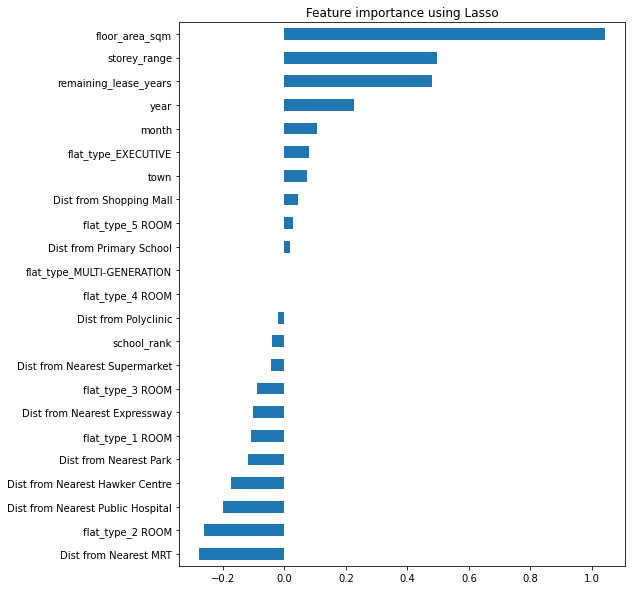

In [ ]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso")

In [ ]:
em_cols = pd_coef.loc[pd_coef['coeff'] != 0, 'feature']
X_train_after = X_train_after[em_cols].copy()

X_train_after.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39648 entries, 101787 to 129978
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   month                              39648 non-null  float64
 1   town                               39648 non-null  float64
 2   storey_range                       39648 non-null  float64
 3   floor_area_sqm                     39648 non-null  float64
 4   year                               39648 non-null  float64
 5   Dist from Nearest Expressway       39648 non-null  float64
 6   Dist from Nearest Hawker Centre    39648 non-null  float64
 7   Dist from Nearest Public Hospital  39648 non-null  float64
 8   Dist from Nearest MRT              39648 non-null  float64
 9   Dist from Nearest Park             39648 non-null  float64
 10  Dist from Polyclinic               39648 non-null  float64
 11  Dist from Primary School           39648 non-nul

## Normalize Test and Validation Sets

In [ ]:
#Normalize the test set
X_test_before = pd.DataFrame(
    scaler_before.transform(X_test_before),
    columns = X_test_before.columns
)


#Normalize the validation set
X_val_before = pd.DataFrame(
    scaler_before.transform(X_val_before),
    columns = X_val_before.columns
)

X_test_before = X_test_before[em_cols]
X_val_before = X_val_before[em_cols]

In [ ]:
#Normalize the test set
X_test_after = pd.DataFrame(
    scaler_after.transform(X_test_after),
    columns = X_test_after.columns
)


#Normalize the validation set
X_val_after = pd.DataFrame(
    scaler_after.transform(X_val_after),
    columns = X_val_after.columns
)

X_test_after = X_test_after[em_cols]
X_val_after = X_val_after[em_cols]

## Before Covid Gradient Boost Model

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
#y_values are logged
#Train set: X_train_before, y_train_before
#Test set: X_test_before, y_test_before
#Valdiation set: X_val_before, y_val_before

gb_model = GradientBoostingRegressor(random_state=0)
gb_model.fit(X_train_before, y_train_before)

GradientBoostingRegressor(random_state=0)

In [ ]:
y_pred = gb_model.predict(X_test_before)

In [ ]:
score = mean_squared_error(y_test_before, gb_model.predict(X_test_before), squared=False)
print(f'RMSE Score on Test set: {score:0.7f}')

RMSE Score on Test set: 0.1066197


In [ ]:
print(f'R Square on Test set: {(r2_score(y_test_before, gb_model.predict(X_test_before))):0.7f}')

R Square on Test set: 0.8885841


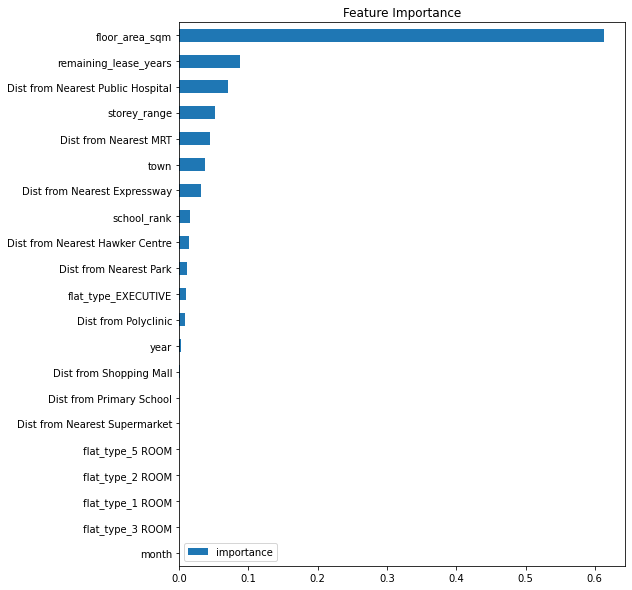

In [ ]:
fi = pd.DataFrame(data=gb_model.feature_importances_,
             index=gb_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Before Covid Gradient Boost Model (Hyperparameter Tuning)

In [ ]:
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from scipy.stats import loguniform

In [ ]:
gb_model = GradientBoostingRegressor()

In [ ]:
## Hyper Parameter Optimization
n_estimators=[1, 2, 5, 10, 20, 50, 100, 200, 500]
max_leaf_nodes=[2, 5, 10, 20, 50, 100]
learning_rate=loguniform(0.01, 1)

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators':n_estimators,
    'max_leaf_nodes':max_leaf_nodes,
    'learning_rate':learning_rate
}

In [ ]:
split_index = [-1]*len(X_train_before) + [0]*len(X_val_before)
X = np.concatenate((X_train_before, X_val_before), axis=0)
y = np.concatenate((y_train_before, y_val_before), axis=0)
pds = PredefinedSplit(test_fold = split_index)

In [ ]:
# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=gb_model,
            param_distributions=hyperparameter_grid,
            cv=pds, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=0)

In [ ]:
random_cv.fit(X, y)

Fitting 1 folds for each of 50 candidates, totalling 50 fits


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=GradientBoostingRegressor(), n_iter=50, n_jobs=4,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F7022C2F28>,
                                        'max_leaf_nodes': [2, 5, 10, 20, 50,
                                                           100],
                                        'n_estimators': [1, 2, 5, 10, 20, 50,
                                                         100, 200, 500]},
                   random_state=0, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=5)

In [ ]:
random_cv.best_estimator_

GradientBoostingRegressor(learning_rate=0.4242243954166456, max_leaf_nodes=100,
                          n_estimators=500)

In [ ]:
gb_model = GradientBoostingRegressor(random_state=0, learning_rate=0.4242243954166456, max_leaf_nodes=100,
                          n_estimators=500)
                     
gb_model.fit(X_train_before, y_train_before)

GradientBoostingRegressor(learning_rate=0.4242243954166456, max_leaf_nodes=100,
                          n_estimators=500, random_state=0)

In [ ]:
gb_model.predict(X_test_before)

array([12.74426883, 13.16093448, 12.93356779, ..., 12.67390012,
       12.5310108 , 13.14027112])

In [ ]:
score = mean_squared_error(y_test_before, gb_model.predict(X_test_before), squared=False)
print(f'RMSE Score on Test set: {score:0.7f}')

RMSE Score on Test set: 0.0636238


In [ ]:
print(f'R Square on Test set: {(r2_score(y_test_before, gb_model.predict(X_test_before))):0.7f}')

R Square on Test set: 0.9603255


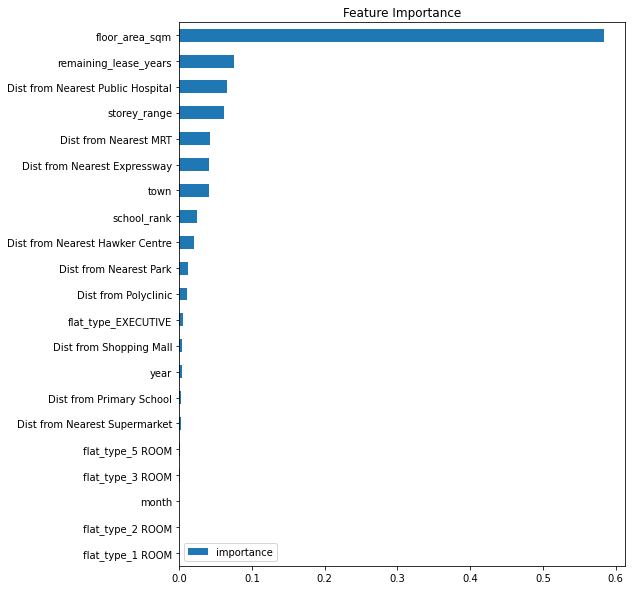

In [ ]:
fi = pd.DataFrame(data=gb_model.feature_importances_,
             index=gb_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## After Covid Gradient Boost Model

In [ ]:
#y_values are logged
#Train set: X_train_after, y_train_after
#Test set: X_test_after, y_test_after
#Valdiation set: X_val_after, y_val_after

gb_model = GradientBoostingRegressor(random_state=0)
gb_model.fit(X_train_after, y_train_after)

GradientBoostingRegressor(random_state=0)

In [ ]:
y_pred = gb_model.predict(X_test_after)

In [ ]:
score = mean_squared_error(y_test_after, gb_model.predict(X_test_after), squared=False)
print(f'RMSE Score on Test set: {score:0.7f}')

RMSE Score on Test set: 0.0981447


In [ ]:
print(f'R Square on Test set: {(r2_score(y_test_after, gb_model.predict(X_test_after))):0.7f}')

R Square on Test set: 0.9035586


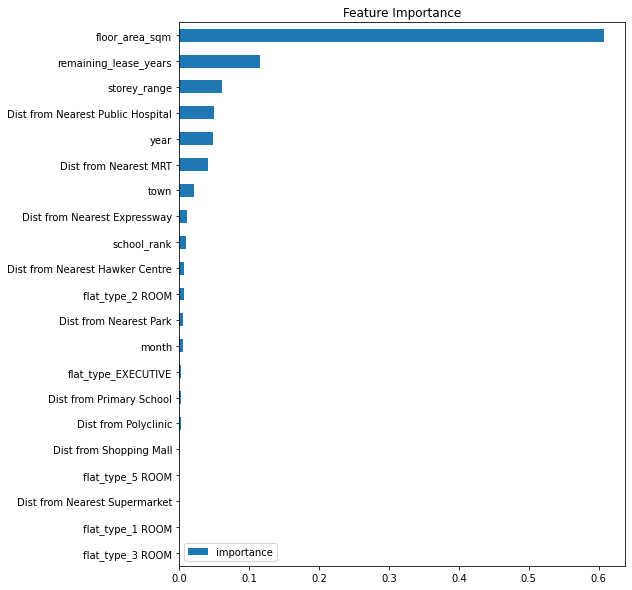

In [ ]:
fi = pd.DataFrame(data=gb_model.feature_importances_,
             index=gb_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## After Covid Gradient Boost Model (Hyperparameter Tuning)

In [ ]:
gb_model = GradientBoostingRegressor()

In [ ]:
## Hyper Parameter Optimization
n_estimators=[1, 2, 5, 10, 20, 50, 100, 200, 500]
max_leaf_nodes=[2, 5, 10, 20, 50, 100]
learning_rate=loguniform(0.01, 1)

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators':n_estimators,
    'max_leaf_nodes':max_leaf_nodes,
    'learning_rate':learning_rate
}

In [ ]:
split_index = [-1]*len(X_train_after) + [0]*len(X_val_after)
X = np.concatenate((X_train_after, X_val_after), axis=0)
y = np.concatenate((y_train_after, y_val_after), axis=0)
pds = PredefinedSplit(test_fold = split_index)

In [ ]:
# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=gb_model,
            param_distributions=hyperparameter_grid,
            cv=pds, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=0)

In [ ]:
random_cv.fit(X, y)

Fitting 1 folds for each of 50 candidates, totalling 50 fits


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=GradientBoostingRegressor(), n_iter=50, n_jobs=4,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F704D07630>,
                                        'max_leaf_nodes': [2, 5, 10, 20, 50,
                                                           100],
                                        'n_estimators': [1, 2, 5, 10, 20, 50,
                                                         100, 200, 500]},
                   random_state=0, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=5)

In [ ]:
random_cv.best_estimator_

GradientBoostingRegressor(learning_rate=0.4242243954166456, max_leaf_nodes=100,
                          n_estimators=500)

In [ ]:
gb_model = GradientBoostingRegressor(random_state=0, learning_rate=0.4242243954166456, max_leaf_nodes=100,
                          n_estimators=500)
                     
gb_model.fit(X_train_after, y_train_after)

GradientBoostingRegressor(learning_rate=0.4242243954166456, max_leaf_nodes=100,
                          n_estimators=500, random_state=0)

In [ ]:
y_pred = gb_model.predict(X_test_after)

In [ ]:
score = mean_squared_error(y_test_after, gb_model.predict(X_test_after), squared=False)
print(f'RMSE Score on Test set: {score:0.7f}')

RMSE Score on Test set: 0.0572021


In [ ]:
print(f'R Square on Test set: {(r2_score(y_test_after, gb_model.predict(X_test_after))):0.7f}')

R Square on Test set: 0.9672393


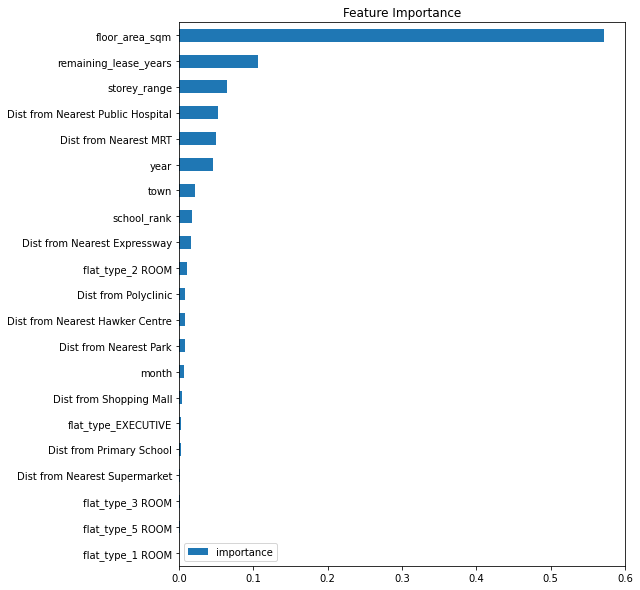

In [ ]:
fi = pd.DataFrame(data=gb_model.feature_importances_,
             index=gb_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()